# MLP Regression Model on engineered features

This notebook is to illustrate the Multi-layer Perceptron (MLP) regression modelling approach to predict the ring radius based on engineered features.

**Important conditions**:
- **Train the regression model on muons only**  
- **Test on testing portion of muons and all pions**  
- **No selection on momentum range**  
- **Only the in-time hits where delta <= 0.5 are included**

- **Regressors (Engineered features used for the models):**
    - `total_in_time_hits`: total number of in-time hits in each event 
    - `x_aligned_min`: minimum hit position realigned by subtracting track position x in each event
    - `x_aligned_max`: maximum hit position realigned by subtracting track position x in each event
    - `y_aligned_min`: minimum hit position realigned by subtracting track position y in each event
    - `y_aligned_max`: maximum hit position realigned by subtracting track position y in each event
    - `x_aligned_width`: maximum hit position x minus minimum hit position x in each event
    - `y_aligned_witdh`: maximum hit position y minus minimum hit position y in each event `
    - `hit_distance_min`: minimum distance between hit position and track position in each event 
    - `hit_distance_max`: maximum distance between hit position and track position in each event 
    - `hit_distance_mean`: mean distance between hit position and track position in each event 
    - `hit_distance_median`: median distance between hit position and track position in each event
    - `hit_distance_q25`: 25% percentile distance between hit position and track position in each event
    - `hit_distance_q75`: 75% percentile distance between hit position and track position in each event
    - `hit_distance_rms`: root mean squared distance between hit position and track position in each event 
    - `hull_area`: hull area of the convex hull
    - `hull_diameter`: the longest line among all the points
    - `hull_diff_width_diameter`: the absolute difference between `hull_diameter` and `hull_width`
    - `hull_width`: closest distance of the parallel lines that encloses all points  

- **Target:**
    - `ring_radius_cal`: calculated ring radius based on the particle mass and track momentum

## Imports

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import pyarrow as pa
# import polars as pl
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

## Read and pre-process data

In [2]:
event_with_hit_features_path = '../../data/events_with_hit_features_[cut_off_time=0.5].parquet'
df = pd.read_parquet(event_with_hit_features_path
                    ).dropna()

# filter df for muons only
df_muons = df.query('label==0')

In [3]:
# split for train and test dataset
train_df, test_df_muon = train_test_split(df_muons, 
                                          random_state=42)
# add pions data into test dataset
test_df = pd.concat([test_df_muon, df.query('label==1')])

In [4]:
# select engineered features for model training
input_features = ['total_in_time_hits','x_aligned_min','x_aligned_max','x_aligned_width',
                  'y_aligned_min','y_aligned_max','y_aligned_width','hit_distance_min',
                  'hit_distance_max','hit_distance_mean','hit_distance_median',
                  'hit_distance_q25','hit_distance_q75','hit_distance_rms',
                  'hull_area','hull_diameter','hull_diff_width_diameter','hull_width']

X_train_raw, y_train = train_df[input_features], train_df['ring_radius_cal']
X_test_raw, y_test = test_df[input_features], test_df['ring_radius_cal']

In [5]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

## Data loader for MLP

In [6]:
# convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy().flatten(), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy().flatten(), dtype=torch.float32)

trainset = TensorDataset(X_train, y_train)

# split trainset to train and validation
train_size = int(0.6 * len(trainset)) # 60% of train data
val_size = len(trainset) - train_size

generator1 = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset=trainset, 
                                  lengths=[train_size, val_size],
                                  generator=generator1)

BATCH_SIZE = 1000 # adjust batch size based on computation resources
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# below code can be modified based on device availability
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


## MLP regression model

In [8]:
def linear_block(input_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.ReLU()
    )

class MLPregression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.main = nn.Sequential(
            linear_block(input_size, 1024),
            linear_block(1024, 512),
            linear_block(512, 256),
            linear_block(256, 64),
            linear_block(64, 12),
            nn.Linear(12, 1)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [9]:
model = MLPregression(len(input_features))
model.to(device)

MLPregression(
  (main): Sequential(
    (0): Sequential(
      (0): Linear(in_features=18, out_features=1024, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=12, bias=True)
      (1): ReLU()
    )
    (5): Linear(in_features=12, out_features=1, bias=True)
  )
)

## Trainer

In [10]:
# below code adopted from MDS DSCI 572 Lecture 5 notes
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        
        # Training
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()       # Clear gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            loss = criterion(y_hat, y)  # Calculate loss
            loss.backward()             # Getting gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()       # Add loss for this batch to running total
            
        train_loss.append(train_batch_loss / len(trainloader))
            
        # Validation
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood

            for X_valid, y_valid in validloader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_hat = model(X_valid).flatten()  # Forward pass to get output
                loss = criterion(y_hat, y_valid)  # Calculate loss based on output

                valid_batch_loss += loss.item()
            
        valid_loss.append(valid_batch_loss / len(validloader))

        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1:3}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.")
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
            
    return train_loss, valid_loss

## Model Training

In [11]:
LEARNING_RATE = 0.0001
criterion = nn.MSELoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [12]:
%%time
train_loss, valid_loss = trainer(model, 
                                 criterion, 
                                 optimizer, 
                                 trainloader,
                                 validloader,
                                 epochs=30, 
                                 patience=5,
                                 verbose=True)

Epoch   1: Train Loss: 4762.665. Valid Loss: 44.426.
Epoch   2: Train Loss: 20.412. Valid Loss: 13.559.
Epoch   3: Train Loss: 12.131. Valid Loss: 11.451.
Epoch   4: Train Loss: 10.729. Valid Loss: 10.372.
Epoch   5: Train Loss: 10.027. Valid Loss: 9.916.
Epoch   6: Train Loss: 9.639. Valid Loss: 9.810.
Epoch   7: Train Loss: 9.271. Valid Loss: 9.502.
Epoch   8: Train Loss: 9.077. Valid Loss: 9.262.
Epoch   9: Train Loss: 8.876. Valid Loss: 8.943.
Epoch  10: Train Loss: 8.668. Valid Loss: 9.580.
Epoch  11: Train Loss: 8.561. Valid Loss: 8.777.
Epoch  12: Train Loss: 8.438. Valid Loss: 8.583.
Epoch  13: Train Loss: 8.311. Valid Loss: 8.559.
Epoch  14: Train Loss: 8.209. Valid Loss: 8.603.
Epoch  15: Train Loss: 8.143. Valid Loss: 8.437.
Epoch  16: Train Loss: 8.068. Valid Loss: 8.754.
Epoch  17: Train Loss: 7.989. Valid Loss: 8.281.
Epoch  18: Train Loss: 7.893. Valid Loss: 8.586.
Epoch  19: Train Loss: 7.835. Valid Loss: 8.179.
Epoch  20: Train Loss: 7.760. Valid Loss: 8.706.
Epoch  21

## Save trained model

In [13]:
# Save the trained model
torch.save(model.state_dict(), '../../saved_models/mlp_model.pth')

## Predictions and performance

In [14]:
# notice that tensor on mps cannot be converted to numpy directly so using to('cpu')
y_test_pred_mlp = model(X_test.to(device)).detach().to('cpu').numpy().squeeze()

In [15]:
y_test_pred_mlp

array([186.67807, 140.38156, 184.7393 , ..., 148.58145, 172.57771,
       181.25192], dtype=float32)

In [16]:
# evaluate r2 score on test dataset
r2_score(y_test, y_test_pred_mlp)

0.9349488986986249

In [17]:
# evaluate MAE score on test dataset
mean_absolute_error(y_test, y_test_pred_mlp)

1.9607495

In [18]:
# create a df with predictions & residuals for test dataset
test_pred_df = pd.DataFrame(y_test_pred_mlp, y_test.numpy()).reset_index()
test_pred_df.columns=['theoretical_radius', 'predicted_radius_mlp']
test_pred_df['residual_mlp'] = test_pred_df['theoretical_radius'] - test_pred_df['predicted_radius_mlp']
test_pred_df

,theoretical_radius,predicted_radius_mlp,residual_mlp
0,185.005157,186.678070,-1.672913
1,137.621536,140.381561,-2.760025
2,186.233276,184.739304,1.493973
3,184.253876,184.165268,0.088608
4,148.973877,151.774979,-2.801102
...,...,...,...
755301,174.585281,172.893967,1.691315
755302,176.125702,180.992813,-4.867111
755303,148.410736,148.581451,-0.170715
755304,172.438187,172.577713,-0.139526


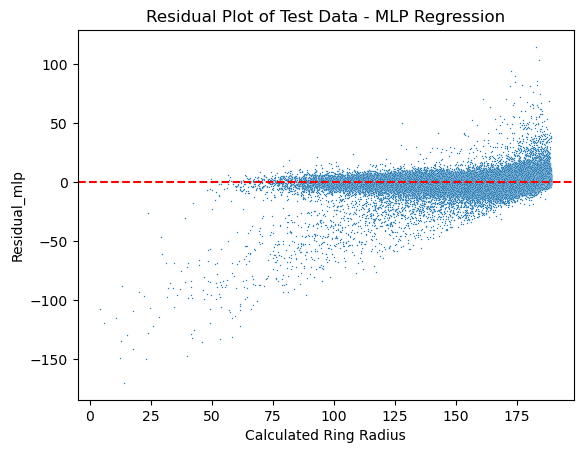

In [19]:
# show the residual plot
sns.scatterplot(data=test_pred_df, x='theoretical_radius', y='residual_mlp', s=1)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot of Test Data - MLP Regression')
plt.xlabel('Calculated Ring Radius')
plt.ylabel('Residual_mlp')

plt.savefig("../../figures/mlp_residual_plot.png")